In [1]:
!which python
!pwd


/home/tristan/miniconda3/envs/.jax_conda_env_MML/bin/python
/home/tristan/ModernML/S4


# Random SSM
This notebook trains a Random SSM on sin(x) or sin(ax+b) sequences. 
The hyperparameters are defined in the `config.yaml` file. 
- N (hidden state dimension): 64
- H (d_model in yaml, number of heads): 10

In [2]:
import jax
import jax.numpy as jnp
import numpy as np

from data import create_sin_ax_b_dataset
from model import BatchStackedModel, MultiHeadSSMLayer, MultiHeadS4DLayer
import torch
from utils import cross_entropy_loss, compute_accuracy
from tqdm import tqdm

In [3]:
rng = jax.random.PRNGKey(1)

In [4]:
from omegaconf import OmegaConf

# load the configuration file
cfg = OmegaConf.load("config.yaml")

In [5]:
dataset = cfg.dataset  # str, sin_ax, sin_ax_b
layer = cfg.layer  # str, s4
seed  = cfg.seed  # int, 0
model = cfg.model  # DictConfig, {d_model: 10 (nb heads), n_layers: 4, dropout: 0.0, prenorm: true, embedding: false, layer: {N:64}}
train = cfg.train  # DictConfig, {epochs: 100, bsz: 128, lr: 0.001, lr_schedule: false, weight_decay: 0.01, checkpoint: false, suffix: null, sample: null}

In [6]:
# Set randomness...
print("[*] Setting Randomness...")
torch.random.manual_seed(seed)  # For dataloader order
key = jax.random.PRNGKey(seed)
key, rng, train_rng = jax.random.split(key, num=3) # TODO: This is bad 


[*] Setting Randomness...


In [7]:
# Check if classification dataset
# because for each dataset there are two versions, eg: mnist and mnist-classification
# TODO: in our case, sin x dataset is not a classification dataset
# classification = "classification" in dataset
classification = False
print(f'{classification=}')

create_dataset_fn = create_sin_ax_b_dataset
trainloader, testloader, n_classes, l_max, d_input, data = create_dataset_fn(n_examples=1024, bsz=train.bsz)
print(f'{n_classes=}, {l_max=}, {d_input=}')

print(f'{next(iter(trainloader))[0].shape=}')
print(f'{next(iter(testloader))[0].shape=}')

classification=False
[*] Generating sin(ax + b) Dataset...
	=>> Generating 1024 Training Examples...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 1308.70it/s]


	=>> Generating 128 Test Examples...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 1509.18it/s]

n_classes=8, l_max=128, d_input=1
next(iter(trainloader))[0].shape=torch.Size([128, 128, 1])
next(iter(testloader))[0].shape=torch.Size([128, 128, 1])


In [19]:
layer_cls = MultiHeadSSMLayer

In [20]:
model.layer.l_max = l_max # l_max comes from the dataset fn

In [21]:
# getattr returns the value of the named attribute of an object. 
# If not found, it returns the default value provided to the function.
lr_layer = getattr(layer_cls, "lr", None)  # lr_layer should be a dictionary
print(f'{lr_layer=} (if None, means that the attribute is not found)')

lr_layer=None (if None, means that the attribute is not found)


In [22]:
from functools import partial

print(f"[*] Starting `{layer}` Training on `{dataset}` =>> Initializing...")

# partial: Return a new partial object which when called will behave like func called with the positional arguments args and keyword arguments keywords.
# a partial object is a wrapper for a callable object. The partial object can be called as though it is the wrapped callable object.
model_cls = partial(
        BatchStackedModel,
        layer_cls=layer_cls,
        d_output=n_classes,
        classification=classification,
        **model,
    )

[*] Starting `s4` Training on `sin_ax_b` =>> Initializing...


In [23]:
import optax
from flax.training import train_state


# TODO: go to create_train_state function (and skip this mapping) it's just a helper function
# As we're using Flax, we also write a utility function to return a default TrainState object.
# This function initializes model parameters, as well as our optimizer. Note that for S4 models,
# we use a custom learning rate for parameters of the S4 kernel (lr = 0.001, no weight decay).
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(nested_dict):
        return {
            k: (map_fn(v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }

    return map_fn
def create_train_state(
    rng,
    model_cls,
    trainloader,
    lr=1e-3,
    lr_layer=None,
    lr_schedule=False,
    weight_decay=0.0,
    total_steps=-1,
):
    print(f'[*] Creating Train State...')
    model = model_cls(training=True)
    init_rng, dropout_rng = jax.random.split(rng, num=2)
    print(f'Init')
    params = model.init(
        {"params": init_rng, "dropout": dropout_rng},
        jnp.array(next(iter(trainloader))[0].numpy()),
    )
    print(f'LRschedule')
    if lr_schedule:
        schedule_fn = lambda lr: optax.cosine_onecycle_schedule(
            peak_value=lr,
            transition_steps=total_steps,
            pct_start=0.1,
        )
    else:
        schedule_fn = lambda lr: lr
    # lr_layer is a dictionary from parameter name to LR multiplier
    if lr_layer is None:
        lr_layer = {}

    tx = optax.adamw(learning_rate=lr, weight_decay=0.01)

    # Print parameter count
    _is_complex = lambda x: x.dtype in [jnp.complex64, jnp.complex128]
    param_sizes = map_nested_fn(
        lambda k, param: param.size * (2 if _is_complex(param) else 1)
        if lr_layer.get(k, lr) > 0.0
        else 0
    )(params)
    print(f"[*] Trainable Parameters: {sum(jax.tree_leaves(param_sizes))}")
    print(f"[*] Total training steps: {total_steps}")

    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx
    )


In [24]:
state = create_train_state(
    rng=rng,
    model_cls=model_cls,
    trainloader=trainloader,
    lr=train.lr,
    lr_layer=lr_layer,
    lr_schedule=train.lr_schedule,
    weight_decay=train.weight_decay,
    total_steps=len(trainloader) * train.epochs,
)

[*] Creating Train State...
Init
LRschedule
[*] Trainable Parameters: 997168
[*] Total training steps: 80


/tmp/ipykernel_1070854/3608746436.py:59: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  print(f"[*] Trainable Parameters: {sum(jax.tree_leaves(param_sizes))}")


In [25]:
@partial(jax.jit, static_argnums=(4, 5))
def train_step(
    state, rng, batch_inputs, batch_labels, model, classification=False
):
    print(f'{batch_inputs.shape=}')
    print(f'{batch_labels.shape=}')
    def loss_fn(params):
        logits, mod_vars = model.apply(
            params,
            batch_inputs,
            rngs={"dropout": rng},
            mutable=["intermediates"],
        )
        loss = jnp.mean(cross_entropy_loss(logits, batch_labels))
        acc = jnp.mean(compute_accuracy(logits, batch_labels))
        return loss, (logits, acc)

    if not classification:
        # For regression tasks, we use the input as the target
        batch_labels = batch_inputs[:, :, 0]
        print(f'{batch_labels.shape=}')

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, acc)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, acc


@partial(jax.jit, static_argnums=(3, 4))
def eval_step(batch_inputs, batch_labels, params, model, classification=False):
    print(f'{batch_inputs.shape=}')
    print(f'{batch_labels.shape=}')
    if not classification:
        batch_labels = batch_inputs[:, :, 0]
    logits = model.apply(params, batch_inputs)
    loss = jnp.mean(cross_entropy_loss(logits, batch_labels))
    acc = jnp.mean(compute_accuracy(logits, batch_labels))
    return loss, acc

In [26]:
def train_epoch(state, rng, model, trainloader, classification=False):
    # Store Metrics
    model = model(training=True)
    batch_losses, batch_accuracies = [], []
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs = jnp.array(inputs.numpy())
        labels = jnp.array(labels.numpy())  # Not the most efficient...
        rng, drop_rng = jax.random.split(rng)
        state, loss, acc = train_step(
            state,
            drop_rng,
            inputs,
            labels,
            model,
            classification=classification,
        )
        batch_losses.append(loss)
        batch_accuracies.append(acc)

    # Return average loss over batches
    return (
        state,
        jnp.mean(jnp.array(batch_losses)),
        jnp.mean(jnp.array(batch_accuracies)),
    )

In [27]:
def validate(params, model, testloader, classification=False):
    # Compute average loss & accuracy
    model = model(training=False)
    losses, accuracies = [], []
    for batch_idx, (inputs, labels) in enumerate(testloader):
        inputs = jnp.array(inputs.numpy())
        labels = jnp.array(labels.numpy())  # Not the most efficient...
        loss, acc = eval_step(
            inputs, labels, params, model, classification=classification
        )
        losses.append(loss)
        accuracies.append(acc)

    return jnp.mean(jnp.array(losses)), jnp.mean(jnp.array(accuracies))


In [28]:
# Loop over epochs
best_loss, best_acc, best_epoch = 10000, 0, 0
print(f"Epoch | Train Loss | Train Acc | Test Loss | Test Acc")
print(f"-------------------------------------------------------")
for epoch in range(train.epochs+3000):
    state, train_loss, train_acc = train_epoch(
        state,
        train_rng,
        model_cls,
        trainloader,
        classification=classification,
    )

    test_loss, test_acc = validate(
        state.params, model_cls, testloader, classification=classification
    )
    print(f'{epoch+1:>5} | {train_loss:.5f}{"":<3} | {train_acc:.4f}{"":<3} | {test_loss:.5f}{"":<2} | {test_acc:.4f}{"":<3}')


Epoch | Train Loss | Train Acc | Test Loss | Test Acc
-------------------------------------------------------
batch_inputs.shape=(128, 128, 1)
batch_labels.shape=(128, 128, 1)
batch_labels.shape=(128, 128)
batch_inputs.shape=(128, 128, 1)
batch_labels.shape=(128, 128, 1)
    1 | 262.24451    | 0.0781    | 41.80103   | 0.0464   
    2 | 19.37352    | 0.0834    | 9.87496   | 0.1223   
    3 | 6.47861    | 0.1170    | 4.28912   | 0.1004   
    4 | 3.88631    | 0.1156    | 3.53186   | 0.1382   
    5 | 3.17543    | 0.1495    | 2.78827   | 0.1381   
    6 | 2.59243    | 0.1356    | 2.28738   | 0.1139   
    7 | 2.24969    | 0.1367    | 2.27439   | 0.1391   
    8 | 2.19797    | 0.1433    | 2.12904   | 0.1458   
    9 | 2.12823    | 0.1539    | 2.08643   | 0.1545   
   10 | 2.08232    | 0.1727    | 2.04257   | 0.1782   
   11 | 2.03890    | 0.1923    | 2.02204   | 0.1929   
   12 | 2.01077    | 0.2056    | 1.98950   | 0.2050   
   13 | 1.98742    | 0.2196    | 1.96683   | 0.2216   
   14 | 1

KeyboardInterrupt: 

In [21]:
inference_model = model_cls(training=False)
batch_inputs, batch_labels = next(iter(trainloader))
logits, model_variables = inference_model.apply(
    state.params,
    jnp.array(batch_inputs),
    rngs={"dropout": rng},
    mutable=["intermediates"],
)

In [73]:
logits.shape

(128, 16, 8)

In [74]:
print(f'{jnp.argmax(logits, axis=-1).shape}')

(128, 16)


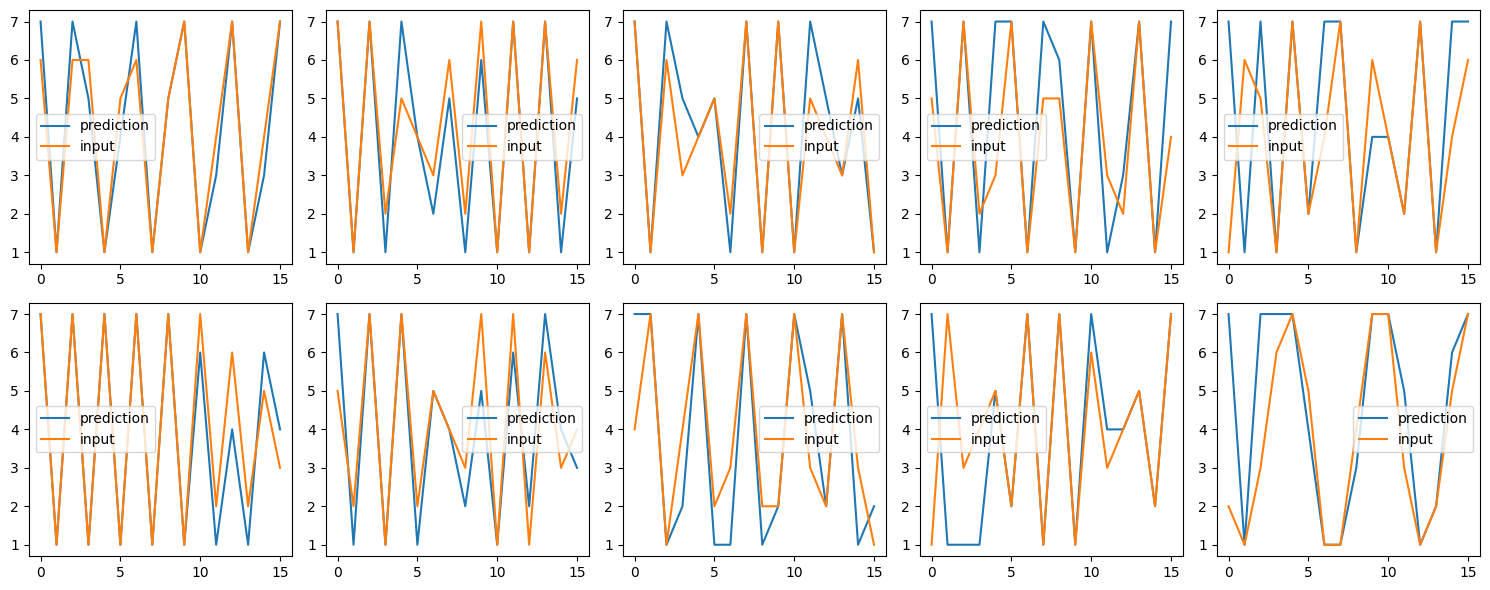

In [75]:
# plot the 10 first examples
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    axs[i // 5, i % 5].plot(jnp.argmax(logits, axis=-1)[i], label='prediction')
    # plot the input
    axs[i // 5, i % 5].plot(batch_inputs[i,:,0], label='input')
    axs[i // 5, i % 5].legend()
plt.tight_layout()
plt.show()


In [27]:
# print state

In [28]:
state.params.keys()

dict_keys(['cache', 'params'])

In [29]:
state.params['params'].keys()

dict_keys(['decoder', 'encoder', 'layers_0', 'layers_1', 'layers_2', 'layers_3'])

In [30]:
next(iter(trainloader))[0].shape

torch.Size([128, 16, 1])

In [31]:
print(state.params['params']['encoder']['bias'].shape)
print(state.params['params']['encoder']['kernel'].shape)


(10,)
(1, 10)


In [32]:
print(state.params['params']['layers_0'].keys())

dict_keys(['norm', 'out', 'out2', 'seq'])


In [44]:
print(state.params['params']['layers_0']['norm'].keys())

dict_keys(['bias', 'scale'])


In [45]:
print(state.params['params']['layers_0']['norm']['bias'].shape)
print(state.params['params']['layers_0']['norm']['scale'].shape)

(10,)
(10,)


In [42]:
print(state.params['params']['layers_0']['out'].keys())
print(state.params['params']['layers_0']['out2'].keys())

dict_keys(['bias', 'kernel'])
dict_keys(['bias', 'kernel'])


In [43]:
print(state.params['params']['layers_0']['out']['bias'].shape)
print(state.params['params']['layers_0']['out']['kernel'].shape)
print(state.params['params']['layers_0']['out2']['bias'].shape)
print(state.params['params']['layers_0']['out2']['kernel'].shape)

(10,)
(10, 10)
(10,)
(10, 10)


In [33]:
print(state.params['params']['layers_0']['seq'].keys())

dict_keys(['A', 'B', 'C', 'D', 'log_step'])


In [34]:
print(state.params['params']['layers_0']['seq']['A'].shape)
print(state.params['params']['layers_0']['seq']['B'].shape)
print(state.params['params']['layers_0']['seq']['C'].shape)
print(state.params['params']['layers_0']['seq']['D'].shape)
print(state.params['params']['layers_0']['seq']['log_step'].shape)


(64, 10, 64)
(64, 10, 1)
(1, 10, 64)
(1, 10)
(1, 10)


In [34]:
print(state.params['params']['layers_0']['seq']['A'][0,0,0])
print(state.params['params']['layers_0']['seq']['A'][0,1,0])
print(state.params['params']['layers_0']['seq']['D'][0,0])
print(state.params['params']['layers_0']['seq']['D'][0,1])

0.002715726
-0.053828467
1.1623794
0.8955986


In [35]:
print(state.params['params']['decoder']['bias'].shape)
print(state.params['params']['decoder']['kernel'].shape)

(8,)
(3, 8)


In [24]:
A = 64**2
B = 64
C = 64
D = 1
H = 10 # number of heads = d_model in yaml
o = 10*10 + 10 
o2 = 10*10 + 10
norm = 10 + 10
seq_p = H*(A+B+C+D) + o + o2 + norm
n_lay = 4
enc = 10+10
dec = 10*8+10
cache_x = 128*64*10 * 4 # = batch_size * N (state dimension) * H (nb heads) * n_lay
n_p = n_lay * seq_p + enc + dec + cache_x
print(f'{n_p=} (should be 497788 -> diff {n_p-497788})')

n_p=497750 (should be 497788 -> diff -38)


In [65]:
n_examples = 1024
SEQ_LENGTH, N_CLASSES, IN_DIM = 16, 8, 1
x = np.linspace(0, 2 * np.pi, num=SEQ_LENGTH)
# jnp.digitize: Return the indices of the bins to which each value in input array belongs.
y = np.digitize(np.sin(x), np.linspace(-1, 1, num=N_CLASSES))

# Tile this `n_examples` times...
# data will be a tensor of shape (n_examples, SEQ_LENGTH, IN_DIM)
data = torch.Tensor(
    np.tile(
        np.expand_dims(np.expand_dims(y, -1), 0), reps=[n_examples, 1, 1]
    )
)
key = jax.random.PRNGKey(0)
key, rng = jax.random.split(key)
amplitudes = jax.random.uniform(rng, shape=(n_examples, 1, 1), minval=0.5, maxval=1.5)
amplitudes = np.array(amplitudes)
data = data * amplitudes


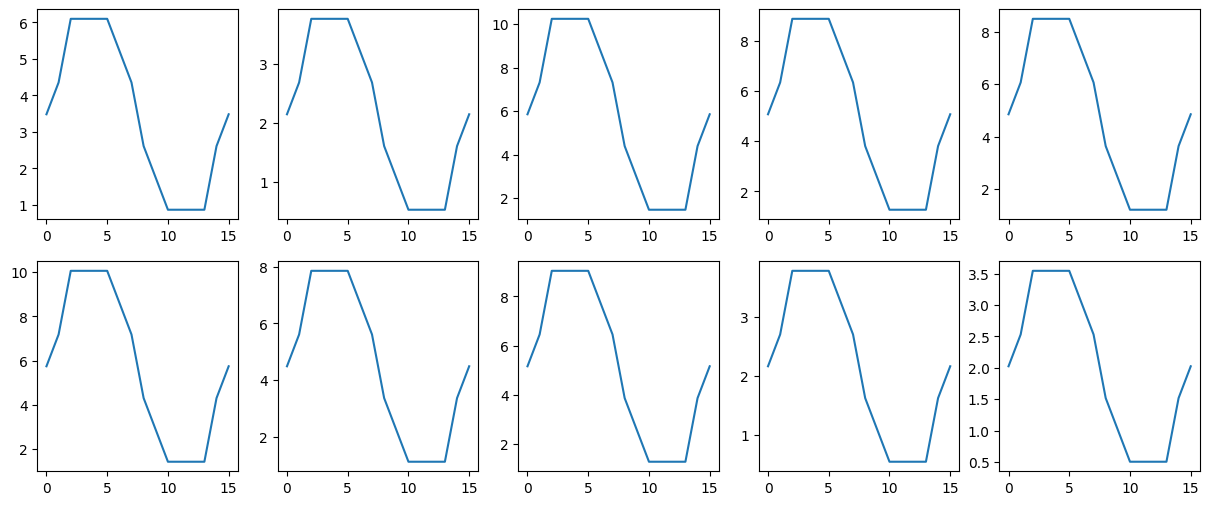

In [66]:
# plot 10 examples
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    axs[i // 5, i % 5].plot(data[i,:,0])
plt.show()


In [76]:
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(k_in, nested_dict):
        if k_in != None: print(f'{k_in}', end=' ')
        return {
            k: (map_fn(k, v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }
    
    return map_fn
    
a = map_nested_fn(lambda k, v: print(f'\n {k, v.shape}'))(None, state.params)

cache layers_0 seq 
 ('cache_x_k', (128, 64, 10))
layers_1 seq 
 ('cache_x_k', (128, 64, 10))
layers_2 seq 
 ('cache_x_k', (128, 64, 10))
layers_3 seq 
 ('cache_x_k', (128, 64, 10))
params decoder 
 ('bias', (8,))

 ('kernel', (10, 8))
encoder 
 ('bias', (10,))

 ('kernel', (1, 10))
layers_0 norm 
 ('bias', (10,))

 ('scale', (10,))
out 
 ('bias', (10,))

 ('kernel', (10, 10))
out2 
 ('bias', (10,))

 ('kernel', (10, 10))
seq 
 ('A', (64, 10, 64))

 ('B', (64, 10, 1))

 ('C', (1, 10, 64))

 ('D', (1, 10))

 ('log_step', (1, 10))
layers_1 norm 
 ('bias', (10,))

 ('scale', (10,))
out 
 ('bias', (10,))

 ('kernel', (10, 10))
out2 
 ('bias', (10,))

 ('kernel', (10, 10))
seq 
 ('A', (64, 10, 64))

 ('B', (64, 10, 1))

 ('C', (1, 10, 64))

 ('D', (1, 10))

 ('log_step', (1, 10))
layers_2 norm 
 ('bias', (10,))

 ('scale', (10,))
out 
 ('bias', (10,))

 ('kernel', (10, 10))
out2 
 ('bias', (10,))

 ('kernel', (10, 10))
seq 
 ('A', (64, 10, 64))

 ('B', (64, 10, 1))

 ('C', (1, 10, 64))

 ('

In [77]:
a

{'cache': {'layers_0': {'seq': {'cache_x_k': None}},
  'layers_1': {'seq': {'cache_x_k': None}},
  'layers_2': {'seq': {'cache_x_k': None}},
  'layers_3': {'seq': {'cache_x_k': None}}},
 'params': {'decoder': {'bias': None, 'kernel': None},
  'encoder': {'bias': None, 'kernel': None},
  'layers_0': {'norm': {'bias': None, 'scale': None},
   'out': {'bias': None, 'kernel': None},
   'out2': {'bias': None, 'kernel': None},
   'seq': {'A': None, 'B': None, 'C': None, 'D': None, 'log_step': None}},
  'layers_1': {'norm': {'bias': None, 'scale': None},
   'out': {'bias': None, 'kernel': None},
   'out2': {'bias': None, 'kernel': None},
   'seq': {'A': None, 'B': None, 'C': None, 'D': None, 'log_step': None}},
  'layers_2': {'norm': {'bias': None, 'scale': None},
   'out': {'bias': None, 'kernel': None},
   'out2': {'bias': None, 'kernel': None},
   'seq': {'A': None, 'B': None, 'C': None, 'D': None, 'log_step': None}},
  'layers_3': {'norm': {'bias': None, 'scale': None},
   'out': {'bias':